In [1]:
import sys
sys.path.insert(0, 'src/')

from ucnnreco import CartesianScampi, NonCartesianScampi
from utils.cartesian.generate_kspace import CartesianKspaceGenerator
from utils.cartesian.transforms import image2kspace_torch, kspace2image_torch
from utils.non_cartesian.generate_kspace import NonCartesianKspaceGenerator
from utils.non_cartesian.sampling import generate_golden_angle_radial_sampling_pattern
from pathlib import Path
from utils.plot_utils import disp
from utils.params import RecoParams,dtype_mapping, dtype_cmapping
import torch



Select the device:

In [2]:

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
else:
    device = torch.device('cpu')


# Radial sampling:

Create and initialize a container for the reconstruction hyperparameters:

In [3]:
ncscampi_params = RecoParams()
ncscampi_params.from_json('src/config/NCScampi.json')

print(ncscampi_params)


name               : Non-Cartesian-Scampi  
dtype              : float32  
learningrate       : 0.003  
batch_size         : 1  
skip_connections   : 0.0  
n_epochs           : 10000  
eta_k              : 20  
eta_img            : 10  
l_l1w              : 2.5e-08  
l_tv               : 0.0  
image_size         : 256,256  
grid_size          : 512,512  
n_coilmaps         : 10  
n_spokes           : 80  
amsgrad            : True  


## Create undersampled k-space data based on the ground truth image:

In [4]:
ck = NonCartesianKspaceGenerator(im_size= tuple(map(int,ncscampi_params['image_size'].split(","))), 
                                 grid_size= tuple(map(int,ncscampi_params['grid_size'].split(","))), 
                                 device=device, 
                                 dtype=torch.float64)

ck.set_traj_generator(generate_golden_angle_radial_sampling_pattern, 
                      spoke_length=256, 
                      num_spokes=ncscampi_params['n_spokes'],
                      dtype=torch.float64)


Create the undersampled k-space data (coilmaps are generated):

In [5]:
kdata = ck.forward(image_path
                   =Path('data/non_cartesian/radial/image/00000006.jpg'),
                   n_coilmaps=ncscampi_params['n_coilmaps'])                

Display the NUFTT-reconstruction:

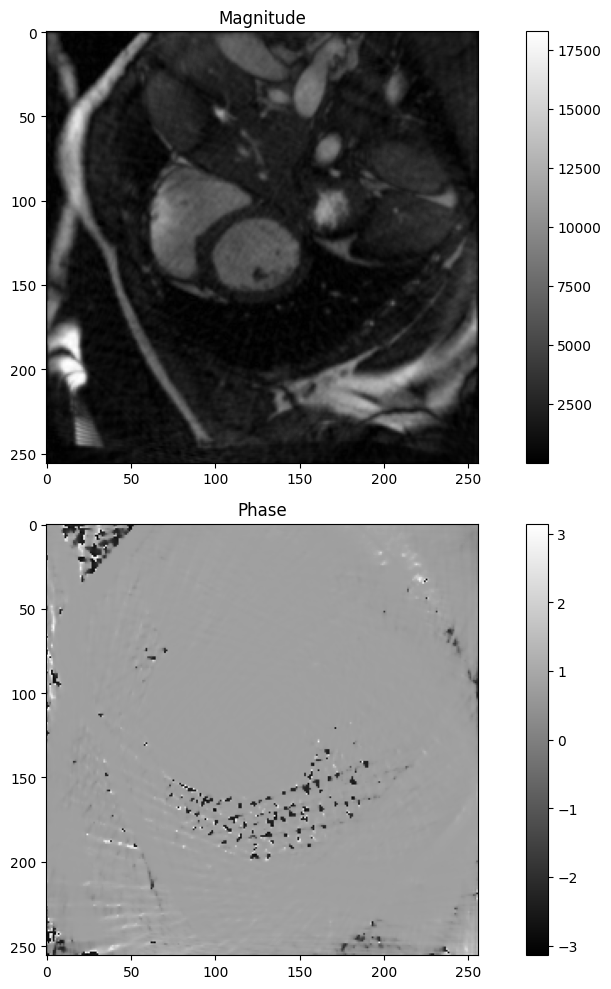

In [6]:
image_data = ck.backward()

disp(image_data, dims=(-1, -2))

Instantiate and initialize the reconstruction object:

In [7]:
reco = NonCartesianScampi(recopars=ncscampi_params, device=device)
reco.set_data_path(image_path=Path('data/non_cartesian/radial/image/00000006.jpg'))
reco.prep_data()

Instantiate and initialize the model:

In [8]:
reco.prep_model()
gt = reco.get_gt()

Perform the reco (i.e. train the model):


In [22]:
res = reco()

  0%|          | 0/10000 [00:00<?, ?it/s]

Show the results:

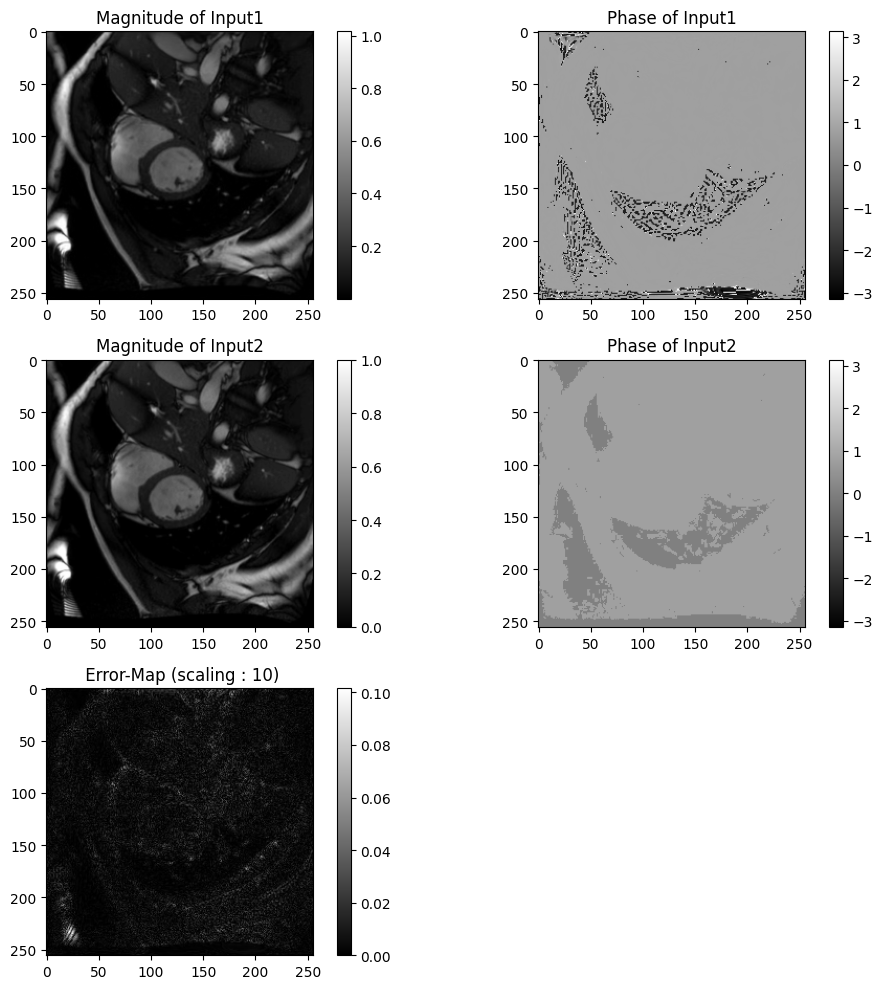

In [23]:
disp(res, gt, dims=(-1, -2), scale_error=10)